# Demonstration of principal curvature determination from a real image

In this notebook, I will use the `curvature` module of my `ridge_trace` package to calculate the principal curvature of an HST optical emission line image of a proplyd bow shock. 

## Imports

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve_fft
from astropy.convolution.kernels import Gaussian2DKernel
from ridge_trace.curvature import ImageCurvature
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

Where to save the figures

In [2]:
figpath = Path.cwd() / "figures"
prefix = "demo01"

## Load the image from a FITS file

Find all the FITS images in the data folder

In [3]:
datapath = Path.cwd().parent / "data"
fitsfiles = list(datapath.glob("*.fits"))
fitsfiles

[PosixPath('/Users/will/Dropbox/ridge-trace/data/w000-400-Bally_09-extract.fits'),
 PosixPath('/Users/will/Dropbox/ridge-trace/data/w069-601-Bally_01-extract.fits')]

Open one of the images and zoom in on the interesting portion

In [4]:
proplyd = "000-400"
hdu = fits.open(fitsfiles[0])["SCI"]
x1, x2 = 200, 500
y1, y2 = 600, 900
xslice, yslice = slice(x1, x2), slice(y1, y2)
data = hdu.data[yslice, xslice]

## Smooth the image

The curvature class can do the smoothing for us, but we want access to the smoothed image for plotting contours, so we will do it ourselves first. 

In [5]:
sigma = 3.0
sdata = convolve_fft(hdu.data, Gaussian2DKernel(sigma))[yslice, xslice]

## Display the image

Use percentiles to choose sensible data limits for the image

In [6]:
vmin, vmax = np.percentile(data, [1, 99])

And plot the image

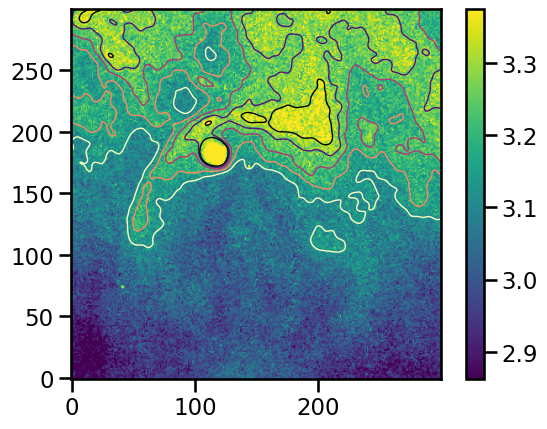

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
levels = 3.12 + np.arange(5) * 0.05
ax.contour(sdata, levels=levels, cmap="magma_r", linewidths=1)
fig.colorbar(im, ax=ax)
...;

## Find the curvatures


Set a typical scale for the gradients as the brightness excess of the arc (about 0.1) divided by the typical width of the arc (of order 20 pixels). This ought to ensure that interesting curvatures are of order unity

In [8]:
v0, d0 = 0.1, 20

In [9]:
ic = ImageCurvature(hdu.data, smooth=3, sharp=None, max_cutoff=3.7, bbox=[x1, y1, x2, y2], scales=(v0, d0))

In [10]:
ic.image.shape

(300, 300)

In [11]:
fig, ax = plt.subplots()
m = np.isfinite(ic.kappa1)
vmin, vmax = np.percentile(ic.image[m], [0.5, 99.5])
im = ax.imshow(ic.image, origin='lower', vmin=vmin, vmax=vmax)
levels = 3.1 + np.arange(7) * 0.05
ax.contour(ic.image, levels=levels, cmap="magma_r", linewidths=1)
fig.colorbar(im, ax=ax)

In [12]:
ic.kappa1

array([[-2.83338882, -3.54562761, -4.26330705, ..., -1.48073582,
        -2.22712818, -2.32682378],
       [-3.70912815, -4.40960125, -4.95505904, ..., -2.2007576 ,
        -2.49700245, -2.27192957],
       [-4.83466337, -5.36363654, -5.51184302, ..., -2.94347828,
        -3.06939416, -2.47375075],
       ...,
       [ 4.31726134,  4.83866354,  5.26851625, ..., -4.58725806,
        -5.12290978, -5.28467527],
       [ 3.73948208,  4.49421682,  5.38170483, ..., -4.85679492,
        -5.36091676, -5.37759945],
       [ 3.50221678,  4.35550855,  5.53392968, ..., -4.23303067,
        -4.91161764, -4.70128799]])

Choose a colormap for the curvature. We want a diverging colormap that has a pale color around zero and contrasting colors for positive and negative values. I choose the `PiYG` colormap, which goes from dark pink to dark green. 

In [13]:
kappa_cmap = 'PiYG'

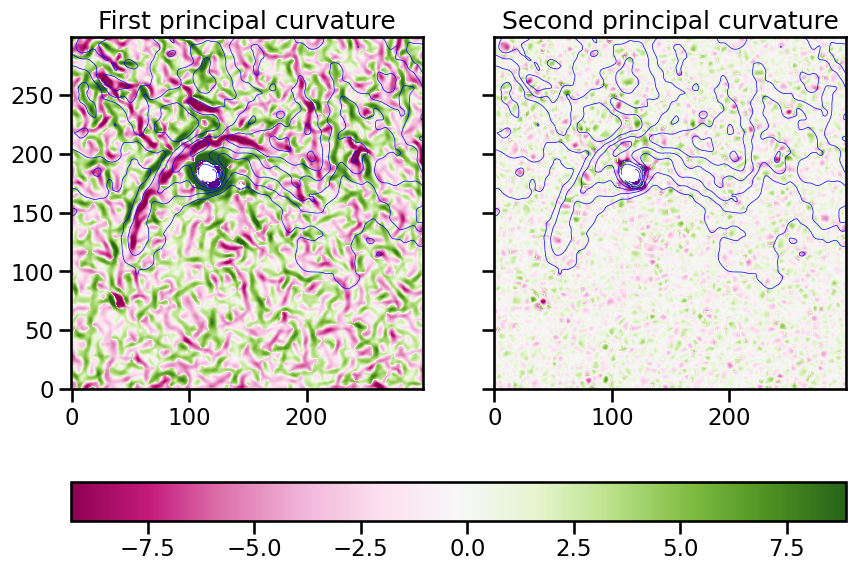

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
vmin, vmax = np.percentile(ic.kappa1[m], [1, 99])
im1 = ax1.imshow(ic.kappa1, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
im2 = ax2.imshow(ic.kappa2, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
fig.colorbar(im1, ax=(ax1, ax2), orientation="horizontal")
for ax in ax1, ax2:
    ax.contour(ic.image, levels=levels, colors="blue", linewidths=0.5)
ax1.set_title("First principal curvature")
ax2.set_title("Second principal curvature")
...;

In [15]:
vmin, vmax

(-9.30076967067678, 8.88909020341877)

Try a bit more smoothing and also filter out the large scales. 

In [16]:
ic2 = ImageCurvature(hdu.data, smooth=4, sharp=50, max_cutoff=3.7, bbox=[x1, y1, x2, y2], scales=(v0, d0))

In [17]:
fig, ax = plt.subplots()
m = np.isfinite(ic2.kappa1)
vmin, vmax = np.percentile(ic2.image[m], [1, 99])
im = ax.imshow(ic2.image, origin='lower', vmin=vmin, vmax=vmax)
levels = 0.03 + np.arange(7) * 0.02

ax.contour(ic2.image, levels=levels, cmap="magma_r", linewidths=1)
fig.colorbar(im, ax=ax)

In [18]:
vmin, vmax

(-0.08194724734605953, 0.11776495677541045)

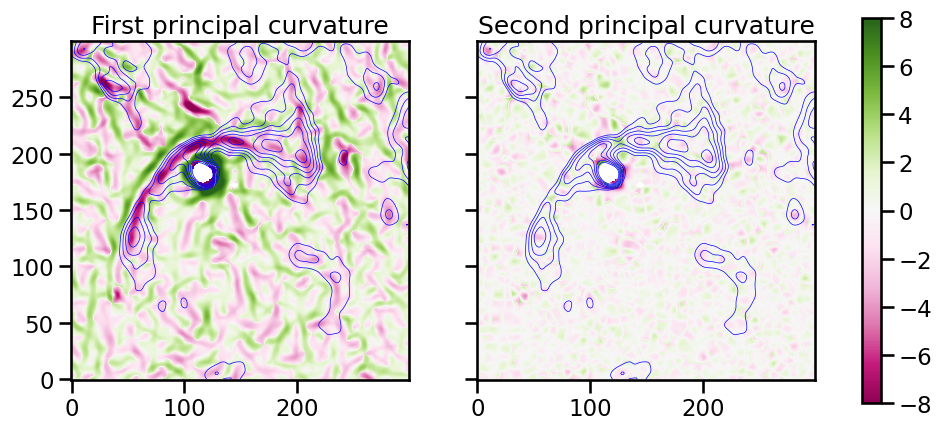

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = -8, 8
im1 = ax1.imshow(ic2.kappa1, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
im2 = ax2.imshow(ic2.kappa2, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic2.image, levels=levels, colors="blue", linewidths=0.5)
ax1.set_title("First principal curvature")
ax2.set_title("Second principal curvature")
...;

In [20]:
fig.savefig(figpath / f"{prefix}-{proplyd}-curvature.pdf", bbox_inches="tight")

Text(0.5, 1.0, 'y-gradient')

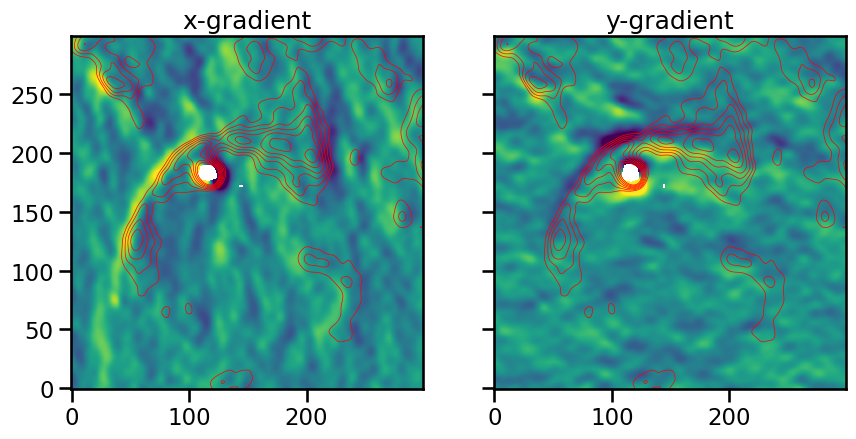

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
vmin, vmax = -2, 2
im1 = ax1.imshow(ic2.grad_x, origin='lower', vmin=vmin, vmax=vmax)
im2 = ax2.imshow(ic2.grad_y, origin='lower', vmin=vmin, vmax=vmax)
for ax in ax1, ax2:
    ax.contour(ic2.image, levels=levels, colors="red", linewidths=0.5)
ax1.set_title("x-gradient")
ax2.set_title("y-gradient")

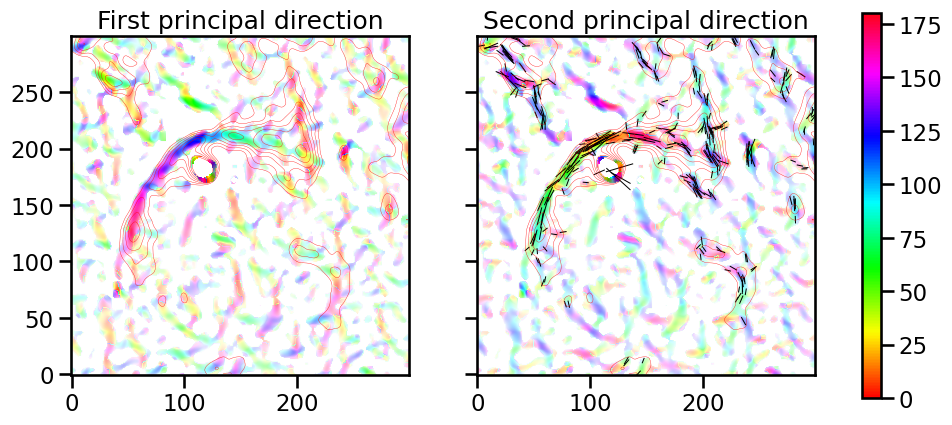

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = 0, 180
ny, nx = ic2.image.shape
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
alpha = -ic2.kappa1/8
alpha[~np.isfinite(alpha)] = 0.0
alpha[alpha < 0] = 0.0
alpha[alpha > 1] = 1.0
im1 = ax1.imshow(ic2.theta1 % 180, origin='lower', vmin=vmin, vmax=vmax, cmap="hsv", alpha=alpha)
im2 = ax2.imshow(ic2.theta2 % 180, origin='lower', vmin=vmin, vmax=vmax, cmap="hsv", alpha=alpha)
kx = np.abs(ic2.kappa1) * np.cos(np.deg2rad(ic2.theta2))
ky = np.abs(ic2.kappa1) * np.sin(np.deg2rad(ic2.theta2))
mask = (ic2.kappa1 < -2) & (ic2.kappa1 * ic2.kappa1 > 0.0) & (ic2.image > levels[0])
narrows = 300
rng = np.random.default_rng()
pts = rng.choice(len(kx[mask]), narrows, replace=False, shuffle=False)
ax2.quiver(X[mask][pts], Y[mask][pts], kx[mask][pts], ky[mask][pts], 
           pivot="middle", color="black", scale=None, width=1, units="dots",
           headwidth=0.0, headlength=0.0, headaxislength=0.0,
          )
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic2.image, levels=levels, colors="red", linewidths=0.25, alpha=1)
ax1.set_title("First principal direction")
ax2.set_title("Second principal direction")
...;

In [23]:
fig.savefig(figpath / f"{prefix}-{proplyd}-direction.pdf", bbox_inches="tight")

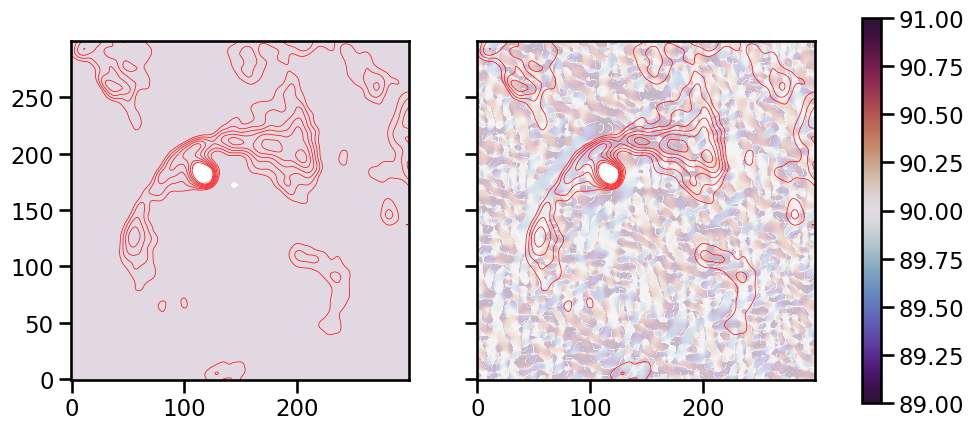

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = 0, 180
im1 = ax1.imshow((ic2.theta1 - ic2.theta2) % 180, origin='lower', vmin=89, vmax=91, cmap="twilight_shifted")
im2 = ax2.imshow(ic2.theta2 % 180, origin='lower', vmin=vmin, vmax=vmax, cmap="twilight_shifted", alpha=0.3)
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic2.image, levels=levels, colors="red", linewidths=0.5)


## Try the other image too

In [25]:
proplyd = "069-601"
hdu = fits.open(fitsfiles[1])["SCI"]

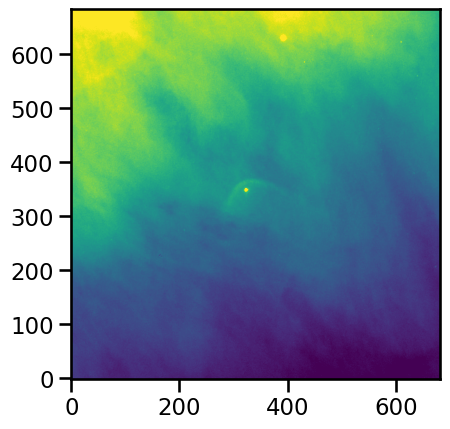

In [26]:
fig, ax = plt.subplots()
vmin, vmax = np.percentile(hdu.data, [1, 99])
ax.imshow(hdu.data, origin="lower", vmin=vmin, vmax=vmax)

In [27]:
x1, x2 = 250, 420
y1, y2 = 250, 420
xslice, yslice = slice(x1, x2), slice(y1, y2)
data = hdu.data[yslice, xslice]

In [28]:
fig, ax = plt.subplots()
vmin, vmax = np.percentile(data, [1, 99])
im = ax.imshow(data, origin="lower", vmin=vmin, vmax=vmax)
fig.colorbar(im)

In [29]:
v0, d0 = 1.0, 20

In [30]:
ic3 = ImageCurvature(hdu.data, smooth=2.5, sharp=40, max_cutoff=8.5, bbox=[x1, y1, x2, y2], scales=(v0, d0))

In [31]:
fig, ax = plt.subplots()
m = np.isfinite(ic3.kappa1)
vmin, vmax = np.percentile(ic3.image[m], [1, 99])
im = ax.imshow(ic3.image, origin='lower', vmin=vmin, vmax=vmax)
levels = 0.0 + np.arange(7) * 0.15

ax.contour(ic3.image, levels=levels, cmap="magma_r", linewidths=1)
fig.colorbar(im, ax=ax)

In [32]:
vmin, vmax

(-0.32852209778038266, 0.5753985709243739)

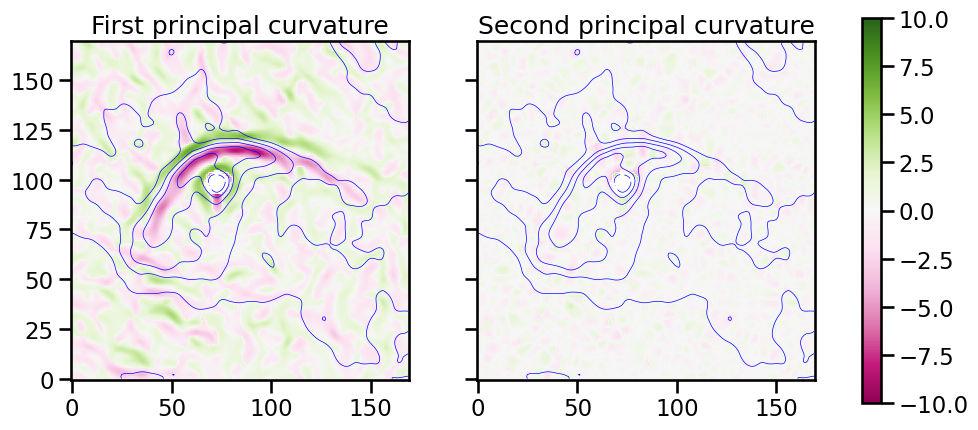

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = -10, 10
im1 = ax1.imshow(ic3.kappa1, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
im2 = ax2.imshow(ic3.kappa2, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic3.image, levels=levels, colors="blue", linewidths=0.5)
ax1.set_title("First principal curvature")
ax2.set_title("Second principal curvature")
...;

In [34]:
fig.savefig(figpath / f"{prefix}-{proplyd}-curvature.pdf", bbox_inches="tight")

In [35]:
import matplotlib as mpl
cmap = sns.color_palette("husl", as_cmap=True)
cmap

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = 0, 180
ny, nx = ic3.image.shape
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
alpha = -ic3.kappa1/8
alpha[~np.isfinite(alpha)] = 0.0
alpha[alpha < 0] = 0.0
alpha[alpha > 1] = 1.0
im1 = ax1.imshow(ic3.theta1 % 180, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, alpha=alpha)
#im2 = ax2.imshow(ic3.theta2 % 180, origin='lower', vmin=vmin, vmax=vmax, cmap="hsv", alpha=alpha)
kx = np.abs(ic3.kappa1) * np.cos(np.deg2rad(ic3.theta2))
ky = np.abs(ic3.kappa1) * np.sin(np.deg2rad(ic3.theta2))
mask = (ic3.kappa1 < -1) & (ic3.kappa1 * ic3.kappa1 > 0.0) & (ic3.image > levels[0])
narrows = 1000
rng = np.random.default_rng()
pts = rng.choice(len(kx[mask]), narrows, replace=False, shuffle=False)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colors = cmap(norm(np.abs(ic3.theta2 % 180)))
ax2.quiver(X[mask][pts], Y[mask][pts], kx[mask][pts], ky[mask][pts], 
           pivot="middle", scale=None, width=1, units="dots",
           color=colors[mask][pts],
           headwidth=0.0, headlength=0.0, headaxislength=0.0,
           alpha=alpha[mask][pts],
          )
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic3.image, levels=levels, colors="k", linewidths=0.25, alpha=1)
    ax.set_aspect('equal')
ax1.set_title("First principal direction")
ax2.set_title("Second principal direction")
...;

In [37]:
fig.savefig(figpath / f"{prefix}-{proplyd}-directions.pdf", bbox_inches="tight")

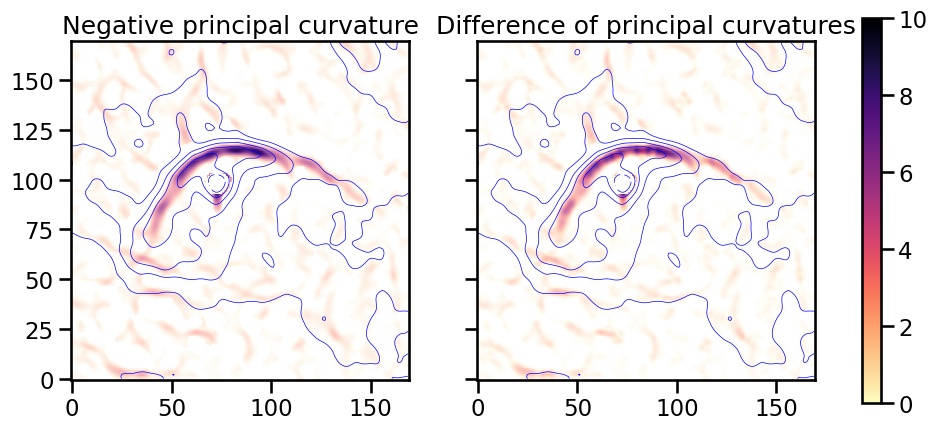

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
vmin, vmax = 0, 10
im1 = ax1.imshow(-ic3.kappa1, origin='lower', vmin=vmin, vmax=vmax, cmap="magma_r", alpha=alpha)
kdiff = np.abs(ic3.kappa1) - np.abs(ic3.kappa2)
im2 = ax2.imshow(kdiff, origin='lower', vmin=vmin, vmax=vmax, cmap="magma_r", alpha=alpha)
fig.colorbar(im1, ax=(ax1, ax2), orientation="vertical")
for ax in ax1, ax2:
    ax.contour(ic3.image, levels=levels, colors="blue", linewidths=0.5)
ax1.set_title("Negative principal curvature")
ax2.set_title("Difference of principal curvatures")
...;

These two are very similar, so it does not seem that the difference provides any useful extra information. Maybe it might be useful in filtering out round sources of similar brightness to the arc (for instance, other stars) but we do not have anything like that in these maps. 

In [ ]:
`2